,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed_up,Date.diff,Distance_Hospital_km,Wealth_Level
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,False,True,False,False,False,False,True,0,3.1,Medium
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,False,False,False,False,False,True,0,3.1,Medium
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,False,False,False,False,False,False,True,0,3.8,High
3,8.679512e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,False,False,False,False,False,False,True,0,2.9,High
4,8.841186e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,True,True,False,False,False,True,0,3.1,Medium


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106987 entries, 0 to 106986
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   PatientId             106987 non-null  float64
 1   AppointmentID         106987 non-null  int64  
 2   Gender                106987 non-null  object 
 3   ScheduledDay          106987 non-null  object 
 4   AppointmentDay        106987 non-null  object 
 5   Age                   106987 non-null  int64  
 6   Neighbourhood         106987 non-null  object 
 7   Scholarship           106987 non-null  bool   
 8   Hipertension          106987 non-null  bool   
 9   Diabetes              106987 non-null  bool   
 10  Alcoholism            106987 non-null  bool   
 11  Handcap               106987 non-null  bool   
 12  SMS_received          106987 non-null  bool   
 13  Showed_up             106987 non-null  bool   
 14  Date.diff             106987 non-null  int64  
 15  

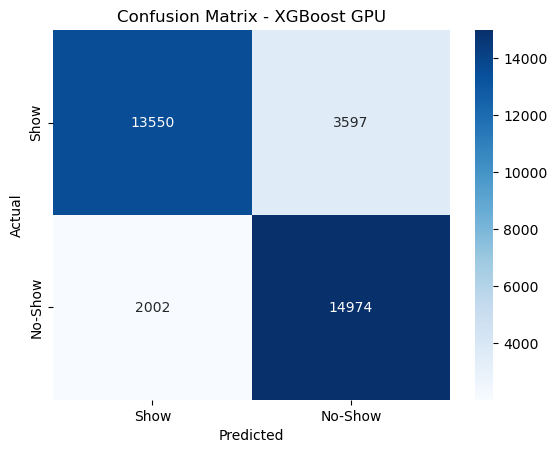

['optimized_xgboost.pkl']

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib
import time

# 1️⃣ Load the dataset
df = pd.read_csv("healthcare_noshows_appt_updated.csv")

# 2️⃣ Initial exploration
display(df.head())
print(df.info())
print(df.describe())

# 3️⃣ Feature engineering

# Create the 'Weekday' feature
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['Weekday'] = df['AppointmentDay'].dt.dayofweek  # 0 = Lunedì, 6 = Domenica

# Categorize age
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 18, 35, 55, 120], labels=['Minor', 'YoungAdult', 'Adult', 'Senior'])

# Create urgency feature for appointment
df['Last_Minute_Appointment'] = (df['Date.diff'] <= 3).astype(int)

# Create distance categories
df['Distance_Category'] = pd.cut(df['Distance_Hospital_km'], bins=[0, 2, 10, np.inf], labels=['Near', 'Medium', 'Far'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['Weekday'] = df['AppointmentDay'].dt.dayofweek  # 0 = Lunedì, 6 = Domenica

# 4️⃣ Save dataset before encoding
pre_encoded_df = df.copy()
pre_encoded_df.to_csv("healthcare_noshows_appt_pre_encoded.csv", index=False)

# 5️⃣ Drop unnecessary columns
drop_columns = ['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay']
df.drop(columns=drop_columns, inplace=True, errors='ignore')

# 5️⃣ Encode categorical variables
categorical_columns = ['Gender', 'Neighbourhood', 'Wealth_Level', 'Weekday', 'Age_Group', 'Distance_Category']
categorical_columns = ['Gender', 'Neighbourhood', 'Wealth_Level', 'Weekday', 'Age_Group', 'Distance_Category']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# 6️⃣ Standardize numerical variables
numerical_columns = ['Age', 'Date.diff', 'Distance_Hospital_km']
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
joblib.dump(scaler, "scaler.pkl")  # Salvataggio dello scaler per uso futuro

# 7️⃣ Separate target and features
target_column = 'Showed_up'
X = df.drop(columns=[target_column])
y = df[target_column]

# 8️⃣ Balance data using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 9️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 🔟 Train XGBoost model on GPU
xgb_model = xgb.XGBClassifier(n_estimators=200, max_depth=10, tree_method='gpu_hist', random_state=42)

start_time = time.time()
xgb_model.fit(X_train, y_train)
gpu_time = time.time() - start_time
print(f"🚀 Tempo di addestramento GPU: {gpu_time:.2f} secondi")

# 1️⃣1️⃣ Model evaluation
xgb_predictions = xgb_model.predict(X_test)
print("XGBoost Metrics:")
print(classification_report(y_test, xgb_predictions))
print("Accuracy:", accuracy_score(y_test, xgb_predictions))
print("AUC Score:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))

# Confusion Matrix
xgb_cm = confusion_matrix(y_test, xgb_predictions)
sns.heatmap(xgb_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Show", "No-Show"], yticklabels=["Show", "No-Show"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost GPU")
plt.show()

# 1️⃣2️⃣ Save modified dataset
df.to_csv("healthcare_noshows_appt_modified.csv", index=False)

# 1️⃣3️⃣ Save optimized model
joblib.dump(xgb_model, "optimized_xgboost.pkl")


In [41]:
import pandas as pd
import joblib
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# 1️⃣ Load the trained model and scaler
xgb_model = joblib.load("optimized_xgboost.pkl")
scaler = joblib.load("scaler.pkl")

# 2️⃣ Define three test patient examples
# Example 1: Likely to Show
# Example 2: Likely to No-Show
# Example 3: Uncertain Case
new_patient = pd.DataFrame([
    # Example 1: Likely to Show
    {
        "Gender_M": 0,  # Female
        "Age": 60,
        "Date.diff": 2,  # Short waiting time
        "Distance_Hospital_km": 1,  # Very close to the hospital
        "Wealth_Level_Medium": 1,
        "Wealth_Level_High": 0,
        "Scholarship": 0,
        "Hipertension": 1,
        "Diabetes": 1,
        "Alcoholism": 0,
        "Handcap": 0,
        "SMS_received": 1,
        "Weekday_1": 0,
        "Weekday_2": 1,  # Tuesday Appointment
        "Weekday_3": 0,
        "Weekday_4": 0,
        "Weekday_5": 0,
        "Weekday_6": 0,
        "Age_Group_YoungAdult": 0,
        "Age_Group_Adult": 0,
        "Age_Group_Senior": 1,
        "Distance_Category_Medium": 0,
        "Distance_Category_Far": 0,
        "Last_Minute_Appointment": 1
    },
    # Example 2: Likely to No-Show
    {
        "Gender_M": 1,  # Male
        "Age": 25,
        "Date.diff": 15,  # Long waiting time
        "Distance_Hospital_km": 15,  # Far from the hospital
        "Wealth_Level_Medium": 0,
        "Wealth_Level_High": 1,
        "Scholarship": 0,
        "Hipertension": 0,
        "Diabetes": 0,
        "Alcoholism": 1,
        "Handcap": 0,
        "SMS_received": 0,
        "Weekday_1": 1,  # Monday Appointment
        "Weekday_2": 0,
        "Weekday_3": 0,
        "Weekday_4": 0,
        "Weekday_5": 0,
        "Weekday_6": 0,
        "Age_Group_YoungAdult": 1,
        "Age_Group_Adult": 0,
        "Age_Group_Senior": 0,
        "Distance_Category_Medium": 0,
        "Distance_Category_Far": 1,
        "Last_Minute_Appointment": 0
    },
    # Example 3: Uncertain Case
    {
        "Gender_M": 1,  # Male
        "Age": 40,
        "Date.diff": 7,  # Medium waiting time
        "Distance_Hospital_km": 5,  # Medium distance
        "Wealth_Level_Medium": 1,
        "Wealth_Level_High": 0,
        "Scholarship": 1,
        "Hipertension": 0,
        "Diabetes": 0,
        "Alcoholism": 0,
        "Handcap": 1,
        "SMS_received": 1,
        "Weekday_1": 0,
        "Weekday_2": 0,
        "Weekday_3": 1,  # Wednesday Appointment
        "Weekday_4": 0,
        "Weekday_5": 0,
        "Weekday_6": 0,
        "Age_Group_YoungAdult": 0,
        "Age_Group_Adult": 1,
        "Age_Group_Senior": 0,
        "Distance_Category_Medium": 1,
        "Distance_Category_Far": 0,
        "Last_Minute_Appointment": 0
    }
])

# 3️⃣ Apply scaling to numerical columns
numerical_columns = ["Age", "Date.diff", "Distance_Hospital_km"]
new_patient[numerical_columns] = scaler.transform(new_patient[numerical_columns])

# 4️⃣ Ensure feature alignment with the trained model
model_features = xgb_model.get_booster().feature_names
for col in model_features:
    if col not in new_patient:
        new_patient[col] = 0  # Add missing features with 0

new_patient = new_patient[model_features]  # Reorder columns to match the model

# 5️⃣ Make a prediction
single_prediction = xgb_model.predict(new_patient)
single_probability = xgb_model.predict_proba(new_patient)[:, 1]

# 6️⃣ Display the results for all test cases
for i in range(len(new_patient)):
    prediction = 'No-Show' if single_prediction[i] == 1 else 'Show'
    probability = single_probability[i]
    print(f"Test Case {i+1}: Predicted Outcome: {prediction}, Probability of No-Show: {probability:.2f}")
print(f"Predicted outcome: {'No-Show' if single_prediction[0] == 1 else 'Show'}")
print(f"Probability of No-Show: {single_probability[0]:.2f}")


Test Case 1: Predicted Outcome: Show, Probability of No-Show: 0.08
Test Case 2: Predicted Outcome: No-Show, Probability of No-Show: 0.67
Test Case 3: Predicted Outcome: No-Show, Probability of No-Show: 0.72
Predicted outcome: Show
Probability of No-Show: 0.08
